In [1]:
import pandas as pd
import os
from fastai.text import *

In [2]:
import numpy as np

In [3]:
os.listdir('../data')

['sample_submission.csv', 'train.csv', 'test.csv']

In [4]:
trn_df = pd.read_csv('../data/train.csv')
tst_df = pd.read_csv('../data/test.csv')

In [5]:
trn_df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [74]:
trn_df.target[:5]

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

In [7]:
trn_df.target = trn_df.target.map(lambda x:1 if x>0.5 else 0)

In [8]:
trn_df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [9]:
trn_pos = trn_df.groupby(by='target')

In [10]:
neg_indx = trn_pos.get_group(0).index

In [11]:
pos_indx = trn_pos.get_group(1).index

In [12]:
neg = np.random.choice(len(neg_indx),size=len(neg_indx)//10,replace=False)

In [13]:
pos = np.random.choice(len(pos_indx), size = len(pos_indx)//10,replace=False)

In [14]:
len(neg),len(pos),len(neg_indx),len(pos_indx)

(169843, 10643, 1698436, 106438)

In [15]:
len(neg_indx)+len(pos_indx)

1804874

In [16]:
neg_indx_val = neg_indx[neg]
pos_indx_val = pos_indx[pos]

In [17]:
val_indx = np.append(neg_indx_val,pos_indx_val)

In [18]:
len(val_indx)

180486

In [19]:
trn_indx = np.setdiff1d(trn_df.index,val_indx)

In [20]:
len(trn_indx)+len(val_indx),len(trn_df)

(1804874, 1804874)

In [21]:
trn_df_trn = trn_df.loc[trn_indx]

In [22]:
val_df = trn_df.loc[val_indx]

In [23]:
len(trn_df_trn),len(val_df)

(1624388, 180486)

In [51]:
#%time data_lm = TextLMDataBunch.from_df('.',train_df=trn_df_trn,valid_df=val_df,test_df=tst_df,text_cols='comment_text',label_cols='target')

In [52]:
#%time data_cls = TextClasDataBunch.from_df('.', train_df=trn_df_trn,valid_df=val_df,test_df=tst_df, vocab=data_lm.train_ds.vocab, text_cols='comment_text',label_cols='target',bs=32)

CPU times: user 1min 47s, sys: 5min 2s, total: 6min 50s
Wall time: 11min 57s


In [54]:
#data_lm.save('data_lm_export.pkl')
#data_cls.save('data_clas_export.pkl')

In [24]:
data_lm = load_data('.', 'data_lm_export.pkl')
data_cls = load_data('.', 'data_clas_export.pkl', bs=32)

In [25]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5).to_fp16()

/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


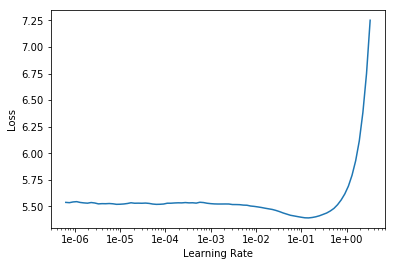

In [28]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.535128,5.336117,0.212744,1:53:06


In [28]:
torch.cuda.empty_cache()

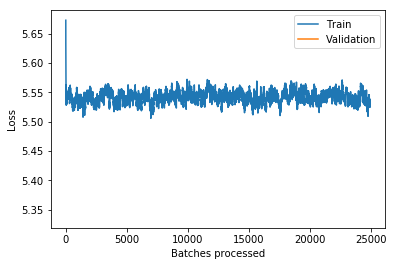

In [29]:
learn.recorder.plot_losses()

In [30]:
learn.unfreeze()

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


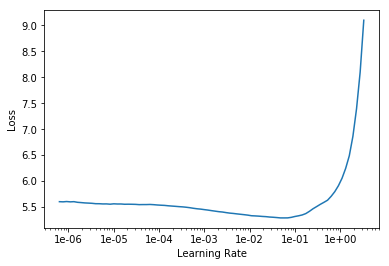

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.527373,5.336119,0.212737,2:05:36


In [34]:
learn.predict("you are looking", n_words=10)

'you are looking back to seen in five films , including the 08'

In [35]:
learn.predict("are you a", n_words=10)

'are you a autograph and a pow ’ s will be found in'

In [36]:
learn.predict("women are", n_words=10)

'women are known to have been fired upon by a killer of'

In [37]:
learn.predict("men have", n_words=10)

'men have realities of cultural Age migration . \n  Ira'

In [38]:
learn.save_encoder('ft_enc')

In [43]:
learn = text_classifier_learner(data_cls, AWD_LSTM, drop_mult=0.5)

/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


In [44]:
learn.load_encoder('ft_enc')

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


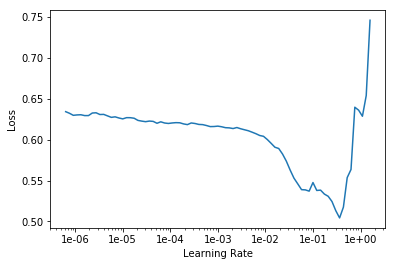

In [46]:
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.218744,0.194532,0.941181,1:10:50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


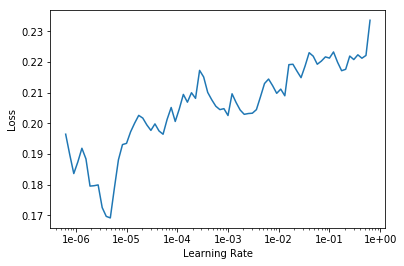

In [49]:
learn.lr_find()
learn.recorder.plot()

In [50]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-4/2., 5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.172309,0.152190,0.948262,1:13:50


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


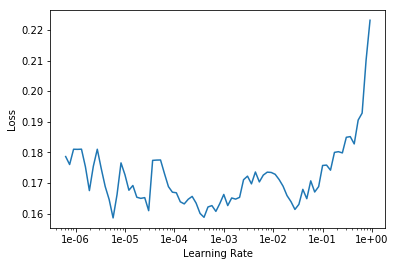

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.111249,0.100292,0.963249,2:26:39


In [53]:
learn.save('final')

In [54]:
learn.predict('women are bad')

(Category 0, tensor(0), tensor([0.9219, 0.0781]))

In [55]:
learn.predict('are women good creatures')

(Category 0, tensor(0), tensor([0.8759, 0.1241]))

In [56]:
learn.predict('are gay good')

(Category 1, tensor(1), tensor([0.0147, 0.9853]))

In [73]:
learn.predict("is sex same as fuck")

(Category 1, tensor(1), tensor([3.9366e-06, 1.0000e+00]))

In [76]:
p = learn.get_preds(DatasetType.Test)

In [79]:
preds = p[0].cpu().numpy()

In [80]:
preds

array([[9.980139e-01, 1.986111e-03],
       [9.997335e-01, 2.664558e-04],
       [9.990391e-01, 9.610142e-04],
       [9.992214e-01, 7.785726e-04],
       ...,
       [8.518455e-01, 1.481546e-01],
       [9.884015e-01, 1.159849e-02],
       [9.244376e-01, 7.556230e-02],
       [9.849712e-01, 1.502880e-02]], dtype=float32)

In [83]:
_ = preds.argmax(axis=1)

In [84]:
_

array([0, 0, 0, 0, ..., 0, 0, 0, 0])

In [85]:
_.sum()

4269

In [86]:
len(_)

97320

In [87]:
string = ''

In [89]:
"a"+str(1)

'a1'

In [90]:
for i in _:
    string = string+'@'+str(i)

In [91]:
string

'@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@1@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@0@